# Open Tu Llave data - Analysis for Scenarios for SDM


In [0]:
import os
from pathlib import Path
from shutil import rmtree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install tqdm
from tqdm import tqdm

!pip install pyunpack
!pip install patool
from pyunpack import Archive



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 3.4 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [0]:
path = '/mnt/DAP/data/ColombiaProject-TransMilenioRawData/'

# Apoyo Subsidy cards stats Dec 2023 - May 2024

Steps:

**1. Get all Apoyo cards transactions**.

For the relevant months, import each transaction dataset, and keep transactions with Nombre_Perfil '(006) Apoyo Ciudadano' or'(009) Apoyo Ciudadano Reexpedición'. Create variables valid (1 for each transaction or validación), trip (1 for each transaction with a value of more than 200 pesos), s_trip (1 for each transaction with a subsidy value of 2230 or 2500 in the relevant period). Concatenate all transactions from Apoyo cards in each month and save them in a dataset called 'df[YYYYMM]apoyo.csv'.

   - _WARNING. Filtering these transactions directly misses the transactions when the same cards were 'Anonymous'. The alternative would be first getting all the Apoyo card numbers and then filtering out all the transactions for those cards. There are pros and cons for each. On one side, this might be preferrable, because there are two ways of becoming Apoyo: (1) from anonymous cards, they keep the same number; (2) from already personalized cards, they get a new number, so we will miss these transactions anyway. On the other side, on our matched TuLlave data we have the IDs, and we only have IDs for personalized cards or Apoyo cards, so we are just missing anonymous cards there._

**2. Monthly stats for Incentivo Sisbén users**.

Import each monthly Apoyo cards transactions dataset, group by card, and sum their validaciones, trips, and subsidy trips. Create the variable 'subsidy' equalling 1 if the card has any subsidy trips that month. Get total cards using Incentivo Sisbén and total, mean, and median validaciones, trips and subsidy trips for them, for each month. Concatenate all monthly summary stats for these cards using incentivo Sisbén and save a dataset called 'apoyo_stats_subsidy.csv'.

 - _PROBLEM IN DECEMBER 2023. Note that for December 2023 we have a peak on the number of Subsidy cards. TransMilenio (Héctor) shared with us the total Incentivo Sisbén users in December 2023 calculated by Recaudo Bogotá and the number is much less (193K, similar to November). Therefore, we should then dig into this deeper to find the problem in these raw data._

**3. Apoyo stats for full 2024 period**.

Import each monthly Apoyo cards transactions dataset, group by card, and sum their validaciones, trips, and subsidy trips. Create the variable 'subsidy' equalling 1 if the card has any subsidy trips that month. Add a variable called "file" referrencing the monthly file. Concatenate all the datasets and save them in 'apoyo_total.csv'. Then, to get stats for the full period: filter cards paying subsidy values each month and (i) count number of unique cards paying subsidy values at some point, (ii) code 0s in trips, s_trips, and trip30 for months when the card is not there in the data or not paying subsidy values.

- _CORRECTION FOR THE FUTURE.  The variable 'subsidy' is created at the card-month level (whether a card is paying subsidy values each month), while it should better created at the card level, for the whole period. So, for that card, we count trips for months before signing up for the subsidy as well._


## 1. Get all Apoyo cards transactions and save monthly apoyo files

In [0]:
perfiles = set()

# Save dataframe for each month:
for m in ['202311', '202312',
          '202401', '202402', '202403', '202404','202405',
          '202406']:
    
    dfapoyo = pd.DataFrame()
    
    for d in ['ValidacionDual/', 'ValidacionTroncal/', 'ValidacionZonal/']:
        folder = path +  '/Workspace/Raw/since2020/' + d
        files = [f.name for f in dbutils.fs.ls(folder) ]
        filesm = [f for f in files if m in f[-12:-6]]

        for f in tqdm(filesm):
            df = pd.read_csv("/dbfs/"+ folder + f,
                            usecols = ['Nombre_Perfil', 'Numero_Tarjeta', 'Valor'] )
            perfiles = perfiles.union(df.Nombre_Perfil)
            df["apoyo"]  = (df.Nombre_Perfil.isin([ '(006) Apoyo Ciudadano','(009) Apoyo Ciudadano Reexpedición'])) 
            df = df[df.apoyo].reset_index(drop = True) 

            dfapoyo = pd.concat([dfapoyo, df])

    dfapoyo["valid"] = 1
    dfapoyo["trip"]   = (dfapoyo.Valor > 200) * 1 
    dfapoyo["s_trip"] = (dfapoyo.Valor.isin([2250, 2500])) * 1 

    filename = 'df' + m + 'apoyo.csv'
    print(filename)
    dfapoyo.to_csv("/dbfs/" + path + '/Workspace/Construct/' + filename, index = False )


100%|██████████| 27/27 [03:02<00:00,  6.75s/it]


df202406apoyo.csv


## 2. Monthly stats for Incentivo Sisbén users.

In [0]:
# Stats by month 
#apoyo_stats = pd.DataFrame()
apoyo_stats = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/apoyo_stats_subsidy.csv')

files = [# '/df202311apoyo.csv', '/df202312apoyo.csv', 
         #'/df202401apoyo.csv', '/df202402apoyo.csv', '/df202403apoyo.csv', '/df202404apoyo.csv', '/df202405apoyo.csv',
         '/df202406apoyo.csv']
for f in files:
   apoyo_stats    = apoyo_stats[apoyo_stats.File != f ].reset_index(drop = True)
   
   dfapoyo = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/' + f)
   dfapoyo = dfapoyo.groupby(['Numero_Tarjeta'], as_index = False)["valid", "trip", "s_trip"].sum() # total trips and valid in the month for each card
   dfapoyo["subsidy"] = dfapoyo.s_trip > 0
   
   aux = dfapoyo.groupby("subsidy", as_index = False).agg({"Numero_Tarjeta": "nunique",
                                                  "valid" : ["sum", "mean", "median"],
                                                  "trip"  : ["sum", "mean", "median"],
                                                  "s_trip": ["sum", "mean", "median"]})
   aux["file"] = f
   aux.columns = ["subsidy",
                       "Total_cards",
                       "Validaciones - total",
                       "Validaciones - mean",
                       "Validaciones - median",
                       "Trips - total",
                       "Trips - mean",
                       "Trips - median",
                       "Subsidy trips - total",
                       "Subsidy trips - mean",
                       "Subsidy trips - median",
                       "File"]

   apoyo_stats = pd.concat([apoyo_stats, aux])



apoyo_stats_subsidy = apoyo_stats[apoyo_stats.subsidy].reset_index(drop = True)

apoyo_stats_subsidy.to_csv("/dbfs/" + path + '/Workspace/Construct/apoyo_stats_subsidy.csv', index = False )

/root/.ipykernel/2423/command-1926342584140210-1978467539:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfapoyo = dfapoyo.groupby(['Numero_Tarjeta'], as_index = False)["valid", "trip", "s_trip"].sum() # total trips and valid in the month for each card


In [0]:
apoyo_stats_subsidy = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/apoyo_stats_subsidy.csv')
apoyo_stats_subsidy["month"] = [f[5:7]+ "-" +f[7:9] for f in apoyo_stats_subsidy.File]
apoyo_stats_subsidy

,subsidy,Total_cards,Validaciones - total,Validaciones - mean,Validaciones - median,Trips - total,Trips - mean,Trips - median,Subsidy trips - total,Subsidy trips - mean,Subsidy trips - median,File,month
0,True,196682,5893978,29.967043,24.0,4322730,21.978269,19.0,3420689,17.391978,18.0,/df202311apoyo.csv,23-11
1,True,243596,6935478,28.471231,23.0,5147343,21.130655,18.0,3253453,13.355938,10.0,/df202312apoyo.csv,23-12
2,True,150271,3935771,26.191155,19.0,2888391,19.221214,15.0,2338817,15.563994,14.0,/df202401apoyo.csv,24-01
3,True,152388,3803183,24.957234,20.0,2784807,18.274451,16.0,2184608,14.335827,15.0,/df202402apoyo.csv,24-02
4,True,151829,4321883,28.465464,23.0,3158427,20.802528,18.0,2622176,17.270587,18.0,/df202403apoyo.csv,24-03
5,True,155410,4868519,31.326935,25.0,3538391,22.768104,20.0,2812011,18.094145,19.0,/df202404apoyo.csv,24-04
6,True,158023,4653755,29.449859,23.0,3383948,21.414275,19.0,2666218,16.872341,18.0,/df202405apoyo.csv,24-05
7,True,158970,4058312,25.528792,19.0,2962908,18.638158,15.0,2578430,16.219601,15.0,/df202406apoyo.csv,24-06


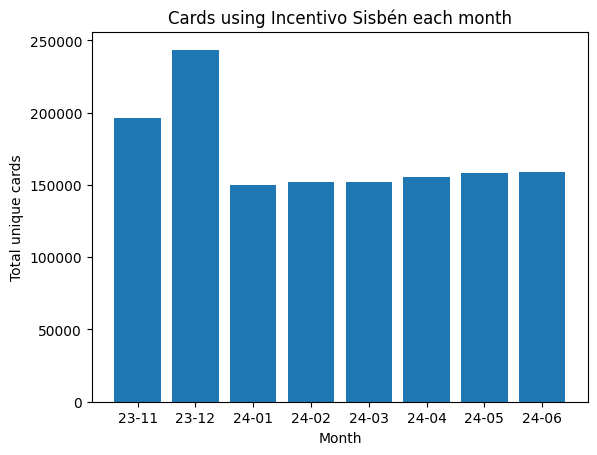

In [0]:
plt.bar("month", "Total_cards", data = apoyo_stats_subsidy)
plt.title("Cards using Incentivo Sisbén each month")
plt.ylabel("Total unique cards")
plt.xlabel("Month")
plt.show()

## 3. Apoyo stats for full 2024 period

In [0]:
# Stats for full 2024 period
#apoyo_total = pd.DataFrame()
apoyo_total = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/apoyo_total.csv')

files = [#'/df202401apoyo.csv', '/df202402apoyo.csv', '/df202403apoyo.csv', '/df202404apoyo.csv', '/df202405apoyo.csv',
          '/df202406apoyo.csv']
for f in files:
   apoyo_total = apoyo_total[apoyo_total.file != f].reset_index(drop = True)
   dfapoyo = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/' + f)
   dfapoyo = dfapoyo.groupby(['Numero_Tarjeta'], as_index = False)["valid", "trip", "s_trip"].sum() # total trips and valid in the month for each card
   dfapoyo["subsidy"] = dfapoyo.s_trip > 0
   dfapoyo["file"] = f
   
   apoyo_total = pd.concat([apoyo_total, dfapoyo])

apoyo_total.to_csv("/dbfs/" + path + '/Workspace/Construct/apoyo_total.csv', index = False )

/root/.ipykernel/2423/command-3325998359063602-2888606290:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfapoyo = dfapoyo.groupby(['Numero_Tarjeta'], as_index = False)["valid", "trip", "s_trip"].sum() # total trips and valid in the month for each card


In [0]:
apoyo_total = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/apoyo_total.csv')
apoyo_total["trip30"] = apoyo_total.trip
apoyo_total.loc[apoyo_total.trip > 30, "trip30"] = 30

In [0]:
print(apoyo_total[apoyo_total.subsidy].Numero_Tarjeta.nunique())
print(apoyo_total[apoyo_total.subsidy].groupby("file").agg({"s_trip" : "sum"}).sum())
print(apoyo_total[apoyo_total.subsidy].groupby("file").agg({"trip30" : "sum"}).sum())
print(apoyo_total[apoyo_total.subsidy].s_trip.mean())

216448

In [0]:
# code 0 if the card does not have subsidy in some other motnh
monthly_avg_0s = apoyo_total[apoyo_total.subsidy].set_index(["Numero_Tarjeta","file"]).unstack(fill_value=0).stack().reset_index()

In [0]:
print(monthly_avg_0s.trip.mean())
print(monthly_avg_0s.s_trip.mean())
print(monthly_avg_0s.trip30.mean())

14.412139020303568

# Get subsidy cards 2024

In [0]:

# Save all cards paying 2250 or 2500 COP

for d in ['ValidacionDual/', 'ValidacionTroncal/', 'ValidacionZonal/']:
    subsidy_cards = pd.DataFrame()
    folder = path +  '/Workspace/Raw/since2020/' + d
    files = [f.name for f in dbutils.fs.ls(folder) ]

    files2024 = [f for f in files if '2024' in f[-12:-8]]

    for f in tqdm(files2024):
        df = pd.read_csv("/dbfs/"+ folder + f)
        scards = df.loc[df.Valor.isin([2250, 2500]), ["Numero_Tarjeta", "Valor", "Nombre_Perfil"]].reset_index(drop = True)
        scards["n"] = 1
        subsidy_cards = pd.concat([subsidy_cards, scards], axis = 0)
        subsidy_cards = subsidy_cards.groupby(["Numero_Tarjeta", "Valor", "Nombre_Perfil"], as_index = False).agg({"n": "sum"})
       
    print("In ", d, ":", subsidy_cards.Numero_Tarjeta.nunique(), "unique subsidy cards")
    print("In ", d, ":", subsidy_cards.Nombre_Perfil.unique())
    subsidy_cards.to_csv("/dbfs/" + path + '/Workspace/Construct/'+d+'subsidy_cards-values-count_Jun24.csv', index = False )


100%|██████████| 167/167 [01:56<00:00,  1.43it/s]


In  ValidacionDual/ : 101403 unique subsidy cards
In  ValidacionDual/ : ['(002) Adulto Mayor' '(009) Apoyo Ciudadano Reexpedición'
 '(006) Apoyo Ciudadano']


100%|██████████| 167/167 [27:21<00:00,  9.83s/it]


In  ValidacionTroncal/ : 629693 unique subsidy cards
In  ValidacionTroncal/ : ['(006) Apoyo Ciudadano' '(002) Adulto Mayor'
 '(009) Apoyo Ciudadano Reexpedición']


100%|██████████| 167/167 [32:04<00:00, 11.52s/it]


In  ValidacionZonal/ : 634719 unique subsidy cards
In  ValidacionZonal/ : ['(002) Adulto Mayor' '(006) Apoyo Ciudadano'
 '(009) Apoyo Ciudadano Reexpedición']


In [0]:
# Save Apoyo subsidy cards
apoyo_subsidy_cards = pd.DataFrame()
for d in ['ValidacionDual/', 'ValidacionTroncal/', 'ValidacionZonal/']:
    df = pd.read_csv("/dbfs/" + path + '/Workspace/Construct/'+d+'subsidy_cards-values-count_Jun24.csv')
    apoyo_subsidy_cards = pd.concat([apoyo_subsidy_cards, df])
apoyo_subsidy_cards = apoyo_subsidy_cards.groupby(["Numero_Tarjeta", "Valor", "Nombre_Perfil"], as_index = False).agg({"n": "sum"})
apoyo_subsidy_cards = apoyo_subsidy_cards[apoyo_subsidy_cards.Nombre_Perfil.isin(['(006) Apoyo Ciudadano', '(009) Apoyo Ciudadano Reexpedición'])].reset_index(drop = True)

In [0]:
apoyo_subsidy_cards = apoyo_subsidy_cards.groupby(["Numero_Tarjeta"], as_index = False).agg({"n": "sum"})